In [1]:
import numpy as np
import pandas as pd
from numpy import matmul
from numpy.linalg import inv, det
from sklearn.cluster import KMeans as kmeans

In [2]:
# Função para selecionar os pontos da RBF randomicamente
def seleciona_centros_rand(pontos, p):
    
    #assert (p<=N/n), "P menor que o número de amostras/número de dimensões"
    centros = []
    
    pnts_rand = pontos[(np.random.choice(pontos.shape[0], size=(2*p), replace=False)), : ]
    pnts_rand = np.split(pnts_rand, p)
    for pnt in pnts_rand:
        centros.append((pnt[0]+pnt[1])/2)
        #raios.append(np.linalg.norm(pontos[0]-pontos[1]))
    labels = []
    for ponto in pontos:
        aux = np.inf
        aux_label = -1
        for i, centro in enumerate(centros):
            if np.linalg.norm(centro-ponto) < aux:
                aux = np.linalg.norm(centro-ponto)
                aux_label = i
        labels.append(aux_label)
        class saida:
            def __init__ (self, centros, labels):
                self.cluster_centers_ = np.array(centros)
                self.labels_ = np.array(labels)
            
    return saida(centros, labels)


#### Função para treinar RBF
def treinaRBF(xin, yin, p, metodo = 'kmeans'):
    
    ######### Função Radial Gaussiana #########
    #Definindo função para calcular a PDF
    def pdf_mv(x, m, K, n):
        if n == 1:
            r = np.sqrt(K)
            px = ((1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * ((x-m)/(r))**2))
        else:
            parte1 = 1/(((2* np.pi)**(n)*(det(K))))
            parte2 = -0.5 * matmul(matmul((x-m).T, (inv(K))), (x-m))
            px = parte1*np.exp(parte2)
        return(px)

    ##################################################

    N = xin.shape[0] # Número de amostras
    n = xin.shape[1] # Dimensão de entrada

    if metodo == 'kmeans':
        xclust = kmeans(n_clusters=p).fit(xin) # Fazendo o Clustering com a função kmeans do sklearn
       
    elif metodo == 'rand':
        xclust = seleciona_centros_rand(xin, p)
    
    else:
        print(f'Metodo {metodo} invalido')
        return

    # Armazena o centro dasd funções
    m = xclust.cluster_centers_
    
    
    covlist = []

    for i in range(p):
        xci = xin[xclust.labels_ == i]
        if n == 1:
            covi = np.var(xci.T)
        else:
            covi = np.cov(xci.T)
        covlist.append(covi)
    H = np.zeros((N, p))

    for j in range(N):
        for i in range(p):
            mi = np.array(m[i, :])
            cov = np.array(covlist[i])
            H[j, i] = pdf_mv(xin[j, :], mi, cov + 1e-3*np.identity(cov.shape[0]), n)

    Haug = np.append(np.ones((N,1)), H, axis = 1)
    W = matmul(np.linalg.pinv(Haug),(yin))

    return(m, covlist, W, H, xclust)

#### Função para encontrar o Y em dado um modelo RBF
def YRBF(xin, modRBF):

    ######### Função Radial Gaussiana #########
    #Definindo função para calcular a PDF
    def pdf_mv(x, m, K, n):
        if n == 1:
            r = np.sqrt(K)
            px = ((1/(np.sqrt(2*np.pi*r*r)))*np.exp(-0.5 * ((x-m)/(r))**2))
        else:
            parte1 = 1/(((2* np.pi)**(n)*(det(K))))
            parte2 = -0.5 * matmul(matmul((x-m).T, (inv(K))), (x-m))
            px = parte1*np.exp(parte2)
        return(px)

    ##################################################

    N = xin.shape[0] # Número de amostras
    n = xin.shape[1] # Dimensão de entrada
    m = modRBF[0]
    covlist = modRBF[1]
    p = len(covlist)
    W = modRBF[2]

    H = np.zeros((N, p))

    for j in range(N):
        for i in range(p):
            mi = m[i, :]
            cov = covlist[i]
            H[j, i] = pdf_mv(xin[j, :], mi, cov + 1e-3*np.identity(cov.shape[0]), n)
    
    Haug = np.append(np.ones((N,1)), H, axis = 1)
    Yhat = matmul(Haug, W)

    return Yhat

In [3]:
data = pd.read_csv('adult_fac.data', index_col = 0)
test = pd.read_csv('adult_fac.test', index_col = 0)

In [4]:
X_data_train = data.iloc[:, 0:-1].to_numpy()
Y_data_train = data.iloc[:, -1].to_numpy()

X_data_test = test.iloc[:, 0:-1].to_numpy()
Y_data_test = test.iloc[:, -1].to_numpy()

In [5]:
Y_data_train = np.where(Y_data_train == 0, -1, 1)
Y_data_test = np.where(Y_data_test == 0, -1, 1)

In [6]:
acc = []
clusters = [2, 5, 10, 20, 30, 50]
for cluster in clusters:
    acc_aux = []
    for i in range(1):
        modelo = treinaRBF(X_data_train, Y_data_train, cluster)
        y_pred = np.where(YRBF(X_data_test, modelo)>0, 1, -1)
        acc_aux.append((y_pred == Y_data_test).mean())
    acc.append(np.mean(acc_aux))

<IPython.core.display.Javascript object>


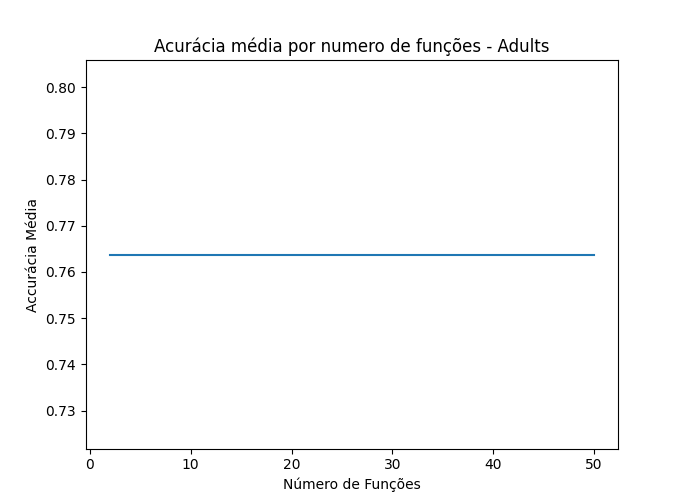

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(clusters, acc)
plt.xlabel('Número de Funções')
plt.ylabel('Accurácia Média')
plt.title('Acurácia média por numero de funções - Adults')
plt.show()